In [20]:
%load_ext autoreload
%autoreload 2

import geoopt
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from geoopt.manifolds.lorentz import Lorentz
from geoopt.manifolds.lorentz import math

from torch.utils.data import TensorDataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def sample_params(dim, zero=False):
    # Generate model parameters
    p = torch.randn((1, dim)) * 2.0
    if zero:
        p /= 1000
    p = man.projx(p) # project onto the hyperboloid 
    man._check_point_on_manifold(p[0])
    orig = man.origin((1, dim))
    beta = torch.randn((1, dim)) * 2.0
    if zero:
        beta /= 1000
    beta /= beta.norm(dim=-1)
    beta = man.proju(orig, beta)
    beta = man.transp(orig, p, beta)
    return p, beta

def plot_params(p, beta):
    p_np = p.numpy()
    beta_np = beta.numpy()
    lins_x = np.linspace(-3, 3, 100)
    linx_y = np.sqrt(k + lins_x**2)
    plt.plot(lins_x, linx_y, color="C1", label="Hyperboloid")
    plt.scatter(p_np[:, 1], p_np[:, 0], label="intercept p")
    plt.arrow(p_np[0, 1], p_np[0, 0], beta_np[0, 1], beta_np[0, 0], 
        width=0.01, color="C2", label="weight beta")
    plt.legend()

def add_noise(y, dim, sig=1.0):
    n = y.shape[0]
    orig = man.origin((1, dim))
    eps = torch.randn(n, dim) * sig
    eps = man.proju(orig, eps)
    eps = man.transp(orig, y, eps)
    ynoise = man.expmap(y, eps)
    return ynoise

def generate_data(n, p, beta, dim):
    x = (torch.rand(n, 1) * 10.0) - 5.0
    y = man.expmap(p, x * beta)
    ynoise = add_noise(y, dim, sig=1.0)
    return x, ynoise, y

k = 50 # choose curvature parameter
d = 80
dim = d + 1
man = Lorentz(k=k)
n_train = 1000
n_test = 500
n = n_train + n_test
p, beta = sample_params(dim)
x, y, y_true = generate_data(n, p, beta, dim)

if d == 1:
    plot_params(p, beta)
    plt.scatter(y[:, 1], y[:, 0], alpha=0.1, color='C3', label='data')
    plt.show()


In [66]:
class GeodesicRegressor():
    def __init__(self, K, dim, man):
        self.K = K
        self.dim = dim
        self.man = man
        q, alpha = sample_params(dim, zero=True)
        self.q = torch.autograd.Variable(q, requires_grad=True)
        self.alpha = torch.autograd.Variable(alpha, requires_grad=True)

    def fit(self, X, Y, epochs=300, lr=0.01, verbose=False):
        n = X.shape[0]

        dataset = TensorDataset(X, Y)
        dataloader = DataLoader(dataset, batch_size=n)
        for e in range(epochs):
            for X, Y in dataloader:
                
                Y_hat = self.man.expmap(self.q, X * self.alpha)
                loss = torch.mean(self.man.dist2(Y, Y_hat))
                #print(f"Loss: {loss.item()}")
                
                # Optimization step
                loss.backward()
                with torch.no_grad():

                    # Get riemannian gradient 
                    dq = self.man.egrad2rgrad(self.q, self.q.grad)
                    qnew = self.man.expmap(self.q, -lr * dq)
                    # Gradient of alpha should be in the tangent space of q
                    dalpha = self.man.egrad2rgrad(self.q, self.alpha.grad)
                    alphanew = self.alpha - (lr * dalpha)
                    alphanew = self.man.transp(self.q, qnew, alphanew)

                    self.alpha.zero_()
                    self.alpha.add_(alphanew)
                    self.q.zero_()
                    self.q.add_(qnew)

                self.alpha.grad.zero_()
                self.q.grad.zero_()

            dataset = TensorDataset(X, Y)
            dataloader = DataLoader(dataset, batch_size=n)
            losses = []
            for X, Y in dataloader:
                with torch.no_grad():
                    Y_hat = self.man.expmap(self.q, X * self.alpha)
                    loss = torch.mean(self.man.dist2(Y, Y_hat))
            losses.append(loss.detach().numpy())

        return losses[-1]

    def predict(self, X):
        Y_hat = man.expmap(self.q, X * self.alpha)
        return Y_hat

model = GeodesicRegressor(k, dim, man)
train_loss =  model.fit(x[:n_train], y[:n_train])
yhat = model.predict(x[n_train:])
val_loss = torch.mean(man.dist2(y[n_train:], yhat))
print(f'Training loss: {train_loss:.4}')
print(f"Validation loss:{val_loss:.4}")

if d == 1:
    plot_params(
        model.q.detach(), 
        model.alpha.detach())

Training loss: 80.29
Validation loss:78.98


100 examples... Validation loss:79.71697235107422
200 examples... Validation loss:79.37655639648438
300 examples... Validation loss:79.2003173828125
400 examples... Validation loss:79.1434097290039
500 examples... Validation loss:79.1370849609375
600 examples... Validation loss:79.05937194824219
700 examples... Validation loss:79.02039337158203
800 examples... Validation loss:79.00634002685547
900 examples... Validation loss:78.98657989501953
1000 examples... Validation loss:78.98410034179688


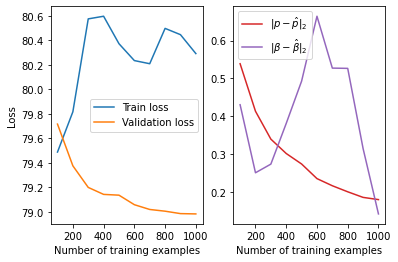

In [67]:
subset_sizes = range(100, n_train+1, 100)
train_losses = []
val_losses = []
pq_norms = []
ba_norms = []

for n_subset in subset_sizes:
    model = GeodesicRegressor(k, dim, man)
    train_loss = model.fit(x[:n_subset], y[:n_subset])
    train_losses.append(train_loss)

    pq_norms.append(
        np.linalg.norm(p[0] - model.q.detach().numpy()[0], ord=2))
    ba_norms.append(
        np.linalg.norm(beta[0] - model.alpha.detach().numpy()[0], ord=2))

    yhat = model.predict(x[n_train:])
    val_loss = torch.mean(man.dist2(y[n_train:], yhat))
    val_losses.append(val_loss.detach().numpy())
    print(f"{n_subset} examples... Validation loss:{val_loss}")


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(subset_sizes, train_losses, label='Train loss')
ax[0].plot(subset_sizes, val_losses, label='Validation loss')
ax[0].set_xlabel('Number of training examples')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(subset_sizes, pq_norms, color='C3', 
    label=r'$\|p - \hat{p}\|_2$')
ax[1].plot(subset_sizes, ba_norms, color='C4', 
    label=r'$\|\beta - \hat{\beta}\|_2$')
ax[1].set_xlabel('Number of training examples')
ax[1].legend()

plt.show()

# Generate LFs

In [109]:
class LFGenerator():
    def __init__(self, num_lfs, siglb=2, sigub=5):
        self.siglb = siglb
        self.sigub = sigub
        self.num_lfs = num_lfs
        self.sigs = []

    def fit(self):
        for i in range(self.num_lfs):
            sig = np.random.uniform(self.siglb, self.sigub)
            self.sigs.append(sig)
    
    def predict(self, Y_true):
        lambdas = []
        for i in range(self.num_lfs):
            lambda_i_preds = add_noise(Y_true, dim, sig=self.sigs[i])
            lambdas.append(lambda_i_preds)
        return lambdas

In [273]:
from tqdm import tqdm

class GeodesicLabelModel():
    def __init__(self, num_triplets=1):
        self.num_triplets = num_triplets
        self.num_lfs = self.num_triplets * 3
        self.thetas = []

    def fit(self, lambdas):
        dim = lambdas[0].shape[1]
        for i in range(self.num_triplets):
            Eab = torch.mean(
                man.dist(lambdas[(i*3)+0], lambdas[(i*3)+1])) / dim
            Ebc = torch.mean(
                man.dist(lambdas[(i*3)+1], lambdas[(i*3)+2])) / dim
            Eac = torch.mean(
                man.dist(lambdas[(i*3)+0], lambdas[(i*3)+2])) / dim
            E = np.array([Eab, Ebc, Eac])
            coef = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]])
            thetas_abc = np.reciprocal(np.linalg.solve(coef, E))
            self.thetas += list(thetas_abc)

    def predict(self, lambdas, max_steps=100, lr=0.001, verbose=False):
        n = lambdas[0].shape[0]
        ys = torch.zeros_like(lambdas[0])
        for i in tqdm(range(n)):
            # Initialize y to be on the manifold
            y = torch.randn_like(lambdas[0][0])
            y = torch.autograd.Variable(man.projx(y), requires_grad=True) 
            
            for step in range(max_steps):
                objective = torch.zeros(1)
                for j in range(self.num_lfs):
                    objective += (
                        self.thetas[j] * man.dist2(lambdas[j][i], y))
                objective.backward()

                # Riemannian descent step
                with torch.no_grad():
                    dy = man.egrad2rgrad(y, y.grad)
                    ynew = man.expmap(y, -lr * dy)
                    y.zero_()
                    y.add_(ynew)
                y.grad.zero_()
            
                if verbose:
                    print(i, step, objective.item())

        return ys


In [281]:
num_lambdas = 10
lfGenerator = LFGenerator(num_lambdas, siglb=1.0, sigub=1.0) # TODO
lfGenerator.fit()
lambdas = lfGenerator.predict(y_true)

In [287]:
labelModel = GeodesicLabelModel(num_triplets=num_lambdas//3)
#lambdas_train = [lambdas[i][:n_train, :] for i in range(len(lambdas))]
labelModel.fit(lambdas) # TODO only fit label model with train examples? 
weak_labels = labelModel.predict(lambdas, max_steps=50, verbose=False)

100%|██████████| 1500/1500 [01:45<00:00, 14.21it/s]


In [288]:
model = GeodesicRegressor(k, dim, man)
train_loss = model.fit(x[:n_train], y[:n_train])

yhat = model.predict(x[n_train:])
val_loss = torch.mean(man.dist2(y[n_train:], yhat))
val_losses.append(val_loss.detach().numpy())
print(f"Validation loss:{val_loss}")

Validation loss:78.98438262939453


In [289]:
weak_label_val_loss = torch.mean(man.dist2(y[n_train:], weak_labels[n_train:]))
weak_label_val_loss

tensor(14911.5898)